In [ ]:
!pip install mido pandas
!pip install pretty_midi
!pip install plotting
import pretty_midi
import numpy as np
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=0d4f39e0fe610886cd4969eb874e37208f26a5852d361aa6d746512d51bb2d2a
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
%%capture
!wget http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz
!tar -xvzf lmd_full.tar.gz
!ls lmd_full  # Adjust the path if necessary
!wget https://colinraffel.com/projects/lmd/match_scores.json

In [ ]:
def compute_statistics(midi_file):
    """
    Given a path to a MIDI file, compute a dictionary of statistics about it

    Parameters
    ----------
    midi_file : str
        Path to a MIDI file.

    Returns
    -------
    statistics : dict
        Dictionary reporting the values for different events in the file.
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)

        note_counts = [len(inst.notes) for inst in pm.instruments]
        pitch_ranges = [(min([note.pitch for note in inst.notes]),
                         max([note.pitch for note in inst.notes])) for inst in pm.instruments if inst.notes]
        avg_note_durations = [sum([note.end - note.start for note in inst.notes]) / len(inst.notes)
                              if inst.notes else 0 for inst in pm.instruments]
        avg_velocities = [sum([note.velocity for note in inst.notes]) / len(inst.notes)
                          if inst.notes else 0 for inst in pm.instruments]
        has_drums = any(inst.is_drum for inst in pm.instruments)

        melodic_intervals = []
        for inst in pm.instruments:
            if inst.notes:
                melodic_intervals += [abs(inst.notes[i + 1].pitch - inst.notes[i].pitch)
                                      for i in range(len(inst.notes) - 1)]
        avg_melodic_interval = sum(melodic_intervals) / len(melodic_intervals) if melodic_intervals else 0

        rhythmic_diversity = []
        for inst in pm.instruments:
            if inst.notes:
                rhythmic_diversity += [note.end - note.start for note in inst.notes]
        rhythmic_variability = (max(rhythmic_diversity) - min(rhythmic_diversity)
                                if rhythmic_diversity else 0)

        drum_patterns = []
        for inst in pm.instruments:
            if inst.is_drum and inst.notes:
                drum_patterns += [note.pitch for note in inst.notes]

        key_modulations = len(pm.key_signature_changes)


        return {
            'n_instruments': len(pm.instruments),     # Total number of instruments in the MIDI file
            'program_numbers': [i.program for i in pm.instruments if not i.is_drum],    # Program numbers for non-drum instruments, indicating their type (e.g., piano, guitar)
            'key_numbers': [k.key_number for k in pm.key_signature_changes], # Key numbers representing detected key signature changes
            # 'tempos': list(pm.get_tempo_changes()[1]), # List of tempos in the MIDI file (helps distinguish between slow and fast genres)
            # 'time_signature_changes': pm.time_signature_changes,  # List of time signature changes, if any (complex time signatures may indicate jazz/classical)
            'end_time': pm.get_end_time(), # Total duration of the piece in seconds
            # 'lyrics': [l.text for l in pm.lyrics], # Lyrics in the MIDI file, if available
            'note_counts': note_counts, # Number of notes played by each instrument
            # 'pitch_ranges': pitch_ranges, # Pitch range for each instrument as a tuple (lowest pitch, highest pitch)
            'avg_note_durations': avg_note_durations, # Average note durations for each instrument
            'avg_velocities': avg_velocities,  # Average velocities for each instrument
            'has_drums': has_drums,        # Whether the piece contains drums
            'drum_patterns': drum_patterns, # Extracted drum patterns, useful for analyzing rhythm sections
            'avg_melodic_interval': avg_melodic_interval, # Average melodic interval across all instruments
            'rhythmic_variability': rhythmic_variability, # Variability in note durations (useful for identifying rhythm complexity)
            'key_modulations': key_modulations, # Number of key modulations (changes in key signature)
            'tempo_estimate': pm.estimate_tempo() #numerical
        }
    except Exception as e:
        pass


In [ ]:
!wget https://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls

--2024-12-02 03:59:28--  https://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls
Resolving www.ifs.tuwien.ac.at (www.ifs.tuwien.ac.at)... 128.131.167.11
Connecting to www.ifs.tuwien.ac.at (www.ifs.tuwien.ac.at)|128.131.167.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11625230 (11M) [text/plain]
Saving to: ‘msd-MAGD-genreAssignment.cls’

msd-MAGD-genreAssig 100%[===================>]  11.09M  2.77MB/s    in 7.2s    

2024-12-02 03:59:36 (1.53 MB/s) - ‘msd-MAGD-genreAssignment.cls’ saved [11625230/11625230]



In [ ]:
def parse_genre_file(genre_file_path):
    genre_mapping = {}
    with open(genre_file_path, 'r') as f:
        for line in f:
            song_id, genre = line.strip().split('\t')
            genre_mapping[song_id] = genre
    return genre_mapping

# Load the genre mappings
genre_file_path = '/content/msd-MAGD-genreAssignment.cls'
genre_mapping = parse_genre_file(genre_file_path)


In [ ]:
import json
import pandas as pd
import pretty_midi
import random

with open('match_scores.json', 'r') as f:# open the file and make it a dictionary
    scores = json.load(f)

seed = 13
random.seed(seed)
random_keys = random.sample(list(scores.keys()), min(1000, len(scores)))
print("Seed used:", seed)

data_dict = []

for key in random_keys: #loop through dictionary
# for key in list(scores.keys())[:1000]: #loop through dictionary
    try:
      matches = scores[key]
      midi_md5 = list(matches.keys())[0] #Grabs the entire file name
      folder = midi_md5[0]  ##first char to find the folder
      file_path = f'lmd_full/{folder}/{midi_md5}.mid' #combine to get the file
      statistics = compute_statistics(file_path) #get stats of file

      if statistics and statistics['end_time'] >= 150:
          song_id = key
          genre = genre_mapping.get(song_id, 'Unknown')
          statistics['genre'] = genre
          data_dict.append(statistics) # add it to a list

    except Exception as e:
      print(f'Error processing {key}: {e}')

# Create a DataFrame
df_dict = pd.DataFrame(data_dict) #create the df

df_dict = df_dict[df_dict['genre'] != 'Unknown']

# Save to CSV
df_dict.to_csv('dictionary_data.csv', index=False) #create a csv that can be used later
df_dict

Seed used: 13


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


,n_instruments,program_numbers,key_numbers,end_time,note_counts,avg_note_durations,avg_velocities,has_drums,drum_patterns,avg_melodic_interval,rhythmic_variability,key_modulations,tempo_estimate,genre
11,9,"[73, 52, 52, 19, 16, 16, 16, 16, 16]",[7],204.166585,"[122, 121, 127, 166, 259, 125, 111, 59, 53]","[0.9153001803278685, 0.9228646446280988, 0.879...","[100.63934426229508, 106.63636363636364, 106.5...",False,[],2.492063,4.791665,1,136.551779,Classical
13,16,"[0, 0, 0, 33, 26, 60, 27, 75, 88, 0, 29]",[0],193.197757,"[137, 371, 249, 510, 317, 101, 64, 125, 196, 2...","[0.5590515145985394, 1.1568621057951463, 1.435...","[75.65693430656934, 59.82479784366577, 66.1767...",True,"[69, 69, 54, 82, 69, 69, 54, 82, 69, 69, 69, 5...",4.932778,7.243812,1,236.153032,Latin
16,13,"[29, 31, 39, 39, 73, 73, 73, 73, 31, 0, 0, 0]",[],279.402864,"[2819, 5, 19, 1694, 1874, 168, 6, 29, 3, 24, 1...","[0.13286700124157214, 0.22388050000000134, 0.2...","[89.36395885065626, 95.0, 100.05263157894737, ...",True,"[49, 40, 40, 40, 40, 40, 40, 36, 40, 40, 40, 3...",6.359029,3.563431,0,267.420782,Pop_Rock
18,10,"[35, 3, 71, 25, 48, 52, 105, 70, 114]",[],223.856472,"[270, 1284, 375, 540, 215, 354, 999, 13, 1613,...","[0.45745116358024657, 0.5338724752563625, 0.35...","[64.12222222222222, 56.96028037383178, 76.488,...",True,"[35, 42, 49, 42, 35, 40, 42, 42, 35, 42, 42, 3...",5.251028,9.233986,0,204.127061,Pop_Rock
22,10,"[88, 90, 50, 39, 33, 4, 24, 75, 75]",[0],256.695588,"[2379, 924, 377, 63, 370, 370, 924, 69, 298, 108]","[0.13043475000000024, 0.8922593289772736, 0.16...","[95.88524590163935, 58.63095238095238, 54.9177...",True,"[51, 42, 35, 42, 42, 42, 42, 42, 42, 42, 35, 4...",9.369891,7.299998,1,231.604769,Pop_Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,11,"[100, 99, 119, 53, 75, 35, 0, 50, 0, 75]",[2],267.222635,"[244, 244, 12, 242, 1745, 312, 106, 362, 106, ...","[0.6147534016393442, 0.6147534016393442, 1.340...","[51.532786885245905, 51.532786885245905, 76.0,...",True,"[36, 42, 36, 82, 42, 82, 42, 38, 42, 36, 36, 4...",10.141888,2.435564,1,192.187134,RnB
836,11,"[1, 22, 1, 89, 33, 26, 65, 28, 27, 49]",[0],314.122293,"[2667, 37, 126, 1018, 402, 360, 297, 454, 532,...","[0.2106793917080662, 0.3357700540540533, 0.480...","[74.00937382827146, 39.108108108108105, 114.89...",True,"[42, 42, 42, 42, 38, 44, 39, 38, 39, 39, 38, 3...",5.557553,7.178595,1,166.263324,Pop_Rock
837,10,"[91, 50, 0, 0, 71, 33, 27, 64, 0]",[],216.257691,"[42, 70, 753, 824, 487, 277, 300, 373, 36, 17]","[0.31222560659722265, 4.164705037202386, 0.016...","[59.80952380952381, 71.78571428571429, 81.5059...",True,"[36, 42, 42, 42, 38, 36, 42, 36, 42, 42, 42, 3...",5.182076,7.883217,0,170.026041,Religious
844,14,"[30, 0, 46, 81, 90, 88, 0, 49, 91, 102, 52, 99]",[0],245.908845,"[1473, 1, 854, 100, 228, 130, 4, 60, 100, 4616...","[0.09469687500000003, 0.094696875000011, 0.087...","[81.25458248472505, 120.0, 87.49414519906323, ...",True,"[31, 31, 42, 46, 42, 46, 42, 46, 42, 46, 42, 4...",8.529426,3.579542,1,264.000264,Pop_Rock


(array([ 7., 31., 43., 84., 48., 49., 10.,  2.,  2.,  3.]),
 array([ 1. ,  3.6,  6.2,  8.8, 11.4, 14. , 16.6, 19.2, 21.8, 24.4, 27. ]),
 <BarContainer object of 10 artists>)

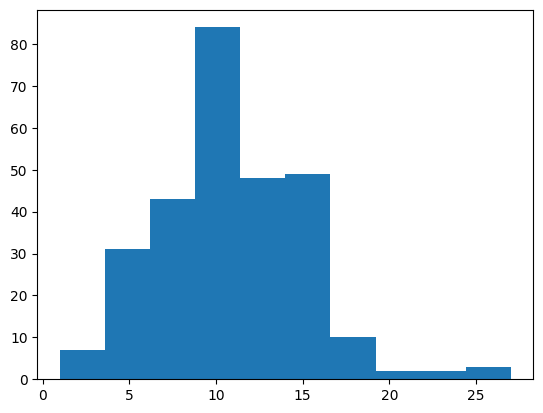

In [ ]:
plt.hist(df_dict['n_instruments'])

The following graph shows the number of instruments for each song. X-axis demonstrating the number of instruments and Y-axis demonstrating the number of songs that have X number of instruments.

(array([ 1.,  0.,  5., 21., 42., 49., 59., 48., 36., 18.]),
 array([ 87.38955823, 107.28582969, 127.18210116, 147.07837262,
        166.97464408, 186.87091554, 206.767187  , 226.66345846,
        246.55972992, 266.45600138, 286.35227285]),
 <BarContainer object of 10 artists>)

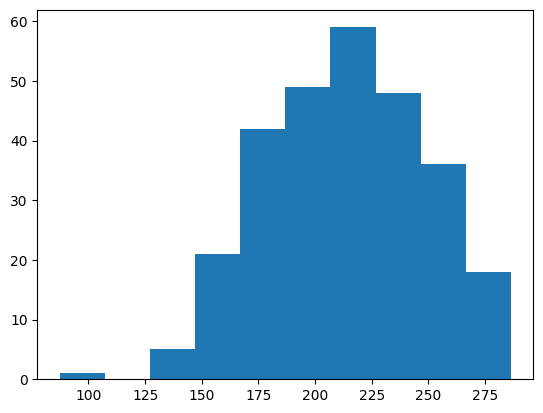

In [ ]:
plt.hist(df_dict['tempo_estimate'])

The following graph shows the tempo estimate of each song. X-axis representing the tempo estimate of a song and Y-axis representing the number of songs that have X tempo estimate.

(array([[0., 6., 0., ..., 0., 0., 0.],
        [4., 0., 4., ..., 0., 0., 0.],
        [3., 0., 3., ..., 0., 0., 0.],
        ...,
        [3., 0., 2., ..., 1., 0., 0.],
        [2., 0., 1., ..., 3., 1., 0.],
        [1., 0., 1., ..., 1., 0., 3.]]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <a list of 279 BarContainer objects>)

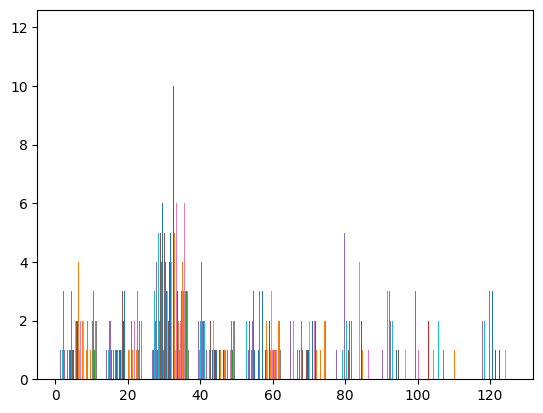

In [ ]:
plt.hist(df_dict['program_numbers'])

## Milestone 3 Preprocessing

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np

# Load the data
df_dict = pd.read_csv('dictionary_data.csv')

# Separate numeric and non-numeric data
numeric_cols = df_dict.select_dtypes(include=np.number).columns
non_numeric_cols = df_dict.select_dtypes(exclude=np.number).columns

# Handle numeric columns
numeric_imputer = SimpleImputer(strategy='most_frequent')
df_numeric = pd.DataFrame(
    numeric_imputer.fit_transform(df_dict[numeric_cols]),
    columns=numeric_cols
)

# Handle non-numeric columns
df_non_numeric = df_dict[non_numeric_cols].copy()

# Process specific non-numeric columns if needed
#for col in non_numeric_cols:
#    df_non_numeric[col] = df_non_numeric[col].apply(
#        lambda x: np.mean(eval(x)) if pd.notnull(x) and isinstance(x, str) and x.startswith("[") else np.nan
#   )

# Impute non-numeric columns
non_numeric_imputer = SimpleImputer(strategy='most_frequent')
df_non_numeric = pd.DataFrame(
    non_numeric_imputer.fit_transform(df_non_numeric),
    columns=non_numeric_cols
)

# Combine numeric and processed non-numeric columns
df_processed = pd.concat([df_numeric, df_non_numeric], axis=1)

# Scale numeric data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# Feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
expanded_features = poly.fit_transform(scaled_features)

# Convert back to DataFrame for expanded features
expanded_df = pd.DataFrame(expanded_features, columns=poly.get_feature_names_out(numeric_cols))

print(f"Preprocessed and expanded features: {expanded_df.shape}")
expanded_df['genre'] = df_dict['genre']
expanded_df

Preprocessed and expanded features: (279, 27)


,n_instruments,end_time,avg_melodic_interval,rhythmic_variability,key_modulations,tempo_estimate,n_instruments^2,n_instruments end_time,n_instruments avg_melodic_interval,n_instruments rhythmic_variability,...,avg_melodic_interval rhythmic_variability,avg_melodic_interval key_modulations,avg_melodic_interval tempo_estimate,rhythmic_variability^2,rhythmic_variability key_modulations,rhythmic_variability tempo_estimate,key_modulations^2,key_modulations tempo_estimate,tempo_estimate^2,genre
0,-0.432960,-0.722675,-1.403669,-0.310286,0.234312,-2.217877,0.187455,0.312890,0.607733,0.134341,...,0.435538,-0.328896,3.113166,0.096277,-0.072703,0.688175,0.054902,-0.519674,4.918977,Classical
1,1.285681,-0.931245,-0.550599,-0.188444,0.234312,0.634928,1.652976,-1.197284,-0.707895,-0.242279,...,0.103757,-0.129012,-0.349591,0.035511,-0.044155,-0.119648,0.054902,0.148771,0.403134,Latin
2,0.549120,0.707924,-0.052100,-0.371314,-0.661208,1.530507,0.301533,0.388736,-0.028609,-0.203896,...,0.019346,0.034449,-0.079740,0.137874,0.245516,-0.568298,0.437196,-1.011984,2.342453,Pop_Rock
3,-0.187440,-0.348277,-0.439365,-0.089556,-0.661208,-0.282368,0.035134,0.065281,0.082355,0.016786,...,0.039348,0.290512,0.124063,0.008020,0.059215,0.025288,0.437196,0.186704,0.079732,Pop_Rock
4,-0.187440,0.276151,1.000247,-0.185652,0.234312,0.504656,0.035134,-0.051762,-0.187486,0.034799,...,-0.185698,0.234369,0.504780,0.034467,-0.043500,-0.093690,0.054902,0.118247,0.254677,Pop_Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.058080,0.476320,1.270073,-0.427355,0.234312,-0.624354,0.003373,0.027665,0.073766,-0.024821,...,-0.542772,0.297593,-0.792975,0.182632,-0.100134,0.266821,0.054902,-0.146293,0.389818,RnB
275,0.058080,1.368106,-0.332230,-0.191684,0.234312,-1.366871,0.003373,0.079460,-0.019296,-0.011133,...,0.063683,-0.077845,0.454115,0.036743,-0.044914,0.262008,0.054902,-0.320274,1.868336,Pop_Rock
276,-0.187440,-0.492766,-0.463465,-0.156673,-0.661208,-1.259098,0.035134,0.092364,0.086872,0.029367,...,0.072612,0.306447,0.583548,0.024546,0.103594,0.197267,0.437196,0.832526,1.585328,Religious
277,0.794641,0.071044,0.706490,-0.370513,0.234312,1.432536,0.631454,0.056454,0.561406,-0.294425,...,-0.261764,0.165539,1.012072,0.137280,-0.086816,-0.530774,0.054902,0.335660,2.052159,Pop_Rock


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Scale the features (exclude 'genre' column from scaling)
# scaler = MinMaxScaler()
# df_norm = pd.DataFrame(scaler.fit_transform(expanded_df.drop(columns='genre')), columns=expanded_df.drop(columns='genre').columns)
df_norm = expanded_df.drop(columns='genre')

# Encode the 'genre' column (target) using LabelEncoder
label_encoder = LabelEncoder()
expanded_df['genre_encoded'] = label_encoder.fit_transform(expanded_df['genre'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_norm, expanded_df['genre_encoded'], test_size=0.20, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


# Train a linear SVM
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

train_pred_linear = svm_linear.predict(X_train)
test_pred_linear = svm_linear.predict(X_test)

print('Linear SVM Classification Report:')
print(classification_report(y_test, test_pred_linear))

# Train an RBF SVM
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
train_pred_rbf = svm_linear.predict(X_train)
test_pred_rbf = svm_rbf.predict(X_test)

print('RBF SVM Classification Report:')
print(classification_report(y_test, test_pred_rbf))

Training data shape: (223, 27)
Testing data shape: (56, 27)
Training labels shape: (223,)
Testing labels shape: (56,)
Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         1
          11       0.53      0.93      0.68        28
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1

    accuracy                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
# Evaluate the model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

train_accuracy = mse(y_train, train_pred_linear)
test_accuracy = mse(y_test, test_pred_linear)
train_accuracy_acc = accuracy_score(y_train, train_pred_linear)
test_accuracy_acc = accuracy_score(y_test, test_pred_linear)

print(f"Training Accuracy Linear MSE: {train_accuracy:.2f}")
print(f"Testing Accuracy Linear MSE: {test_accuracy:.2f}")
print(f"Training Accuracy Linear ACC: {train_accuracy_acc:.2f}")
print(f"Testing Accuracy Linear ACC: {test_accuracy_acc:.2f}")

train_accuracy_rbf = mse(y_train, train_pred_rbf)
test_accuracy_rbf = mse(y_test, test_pred_rbf)
train_accuracy_rbf_acc = accuracy_score(y_train, train_pred_rbf)
test_accuracy_rbf_acc = accuracy_score(y_test, test_pred_rbf)

print(f"Training Accuracy RBF MSE: {train_accuracy_rbf:.2f}")
print(f"Testing Accuracy RBF MSE: {test_accuracy_rbf:.2f}")
print(f"Training Accuracy RBF ACC: {train_accuracy_rbf_acc:.2f}")
print(f"Testing Accuracy RBF ACC: {test_accuracy_rbf_acc:.2f}")


Training Accuracy Linear MSE: 5.80
Testing Accuracy Linear MSE: 19.73
Training Accuracy Linear ACC: 0.73
Testing Accuracy Linear ACC: 0.46
Training Accuracy RBF MSE: 5.80
Testing Accuracy RBF MSE: 17.12
Training Accuracy RBF ACC: 0.73
Testing Accuracy RBF ACC: 0.50


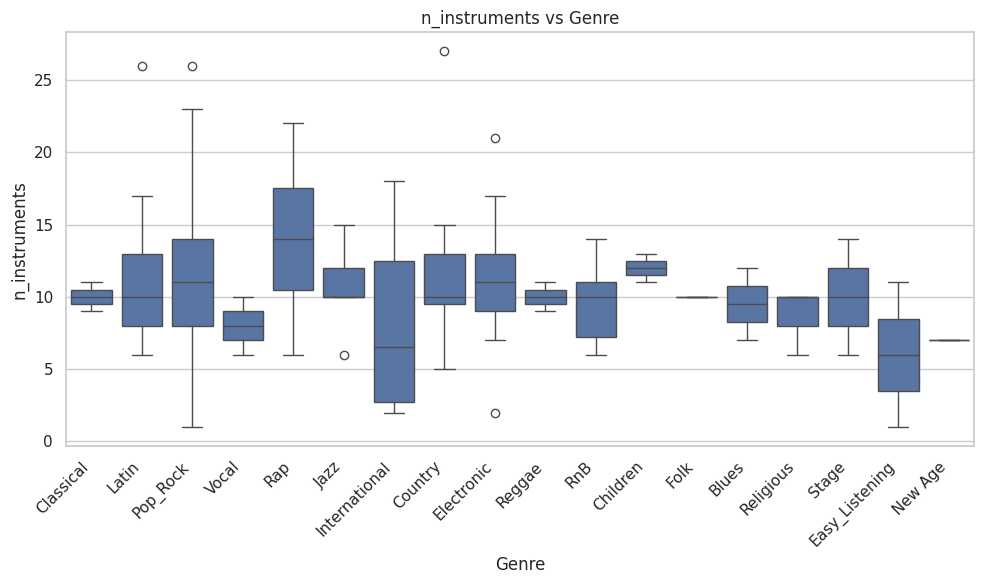

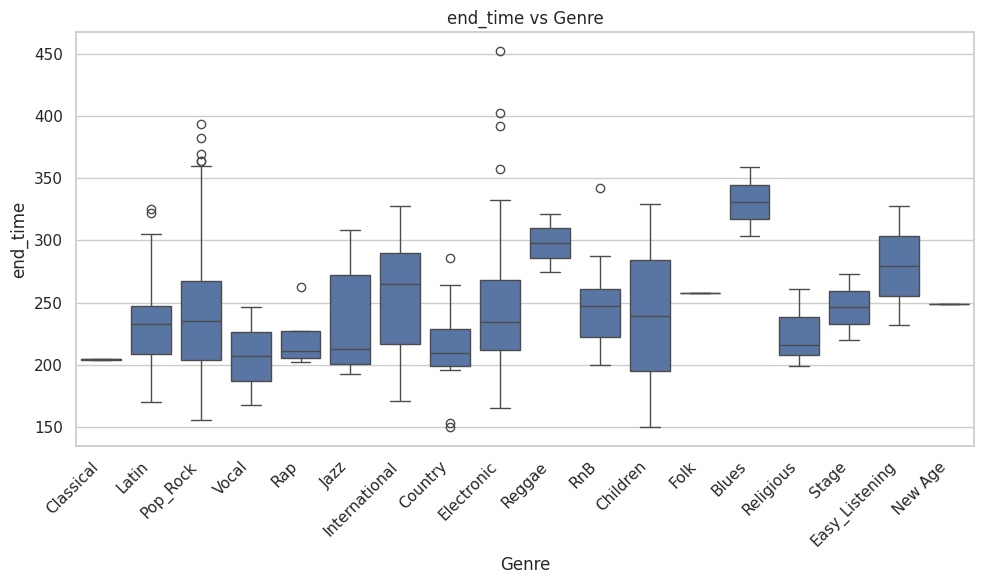

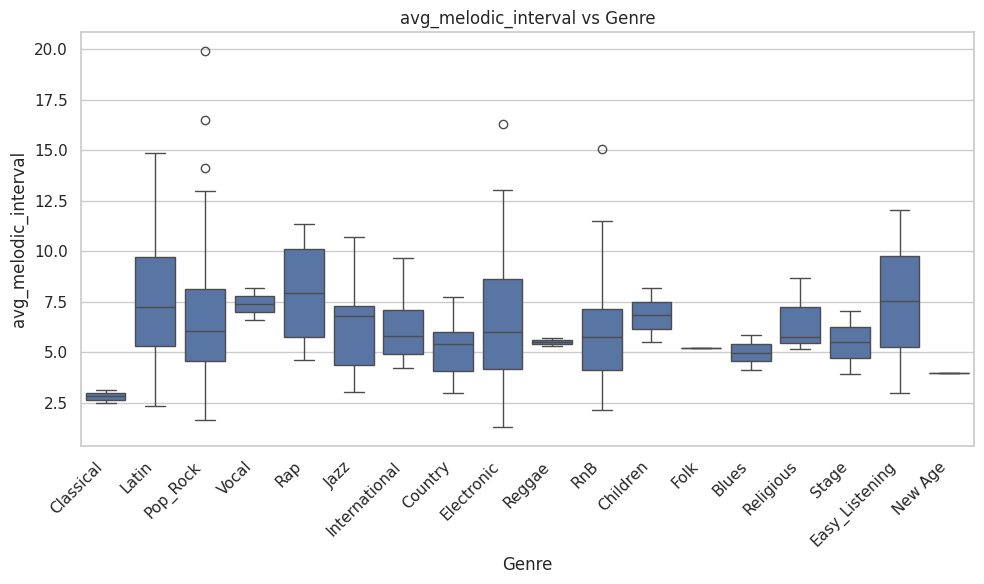

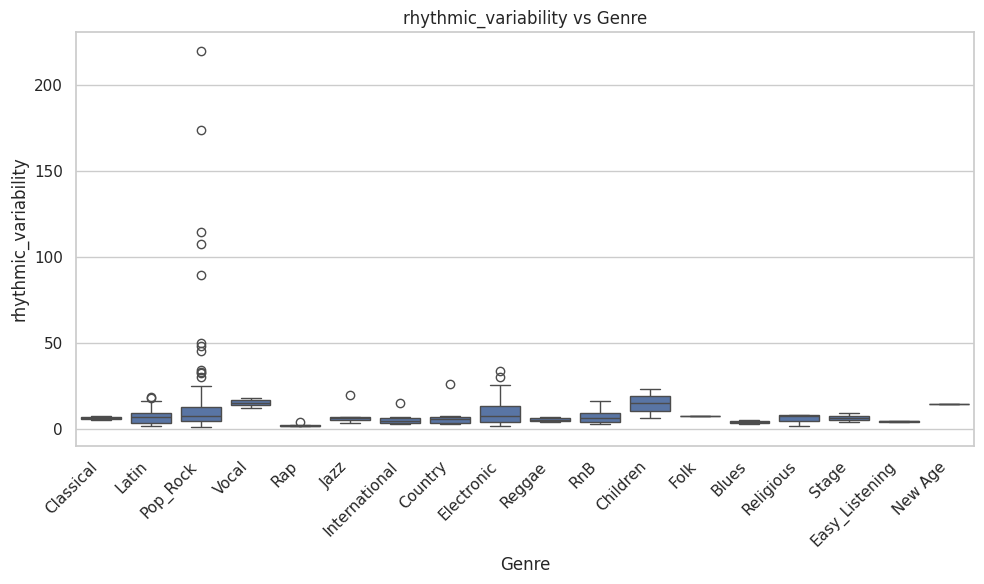

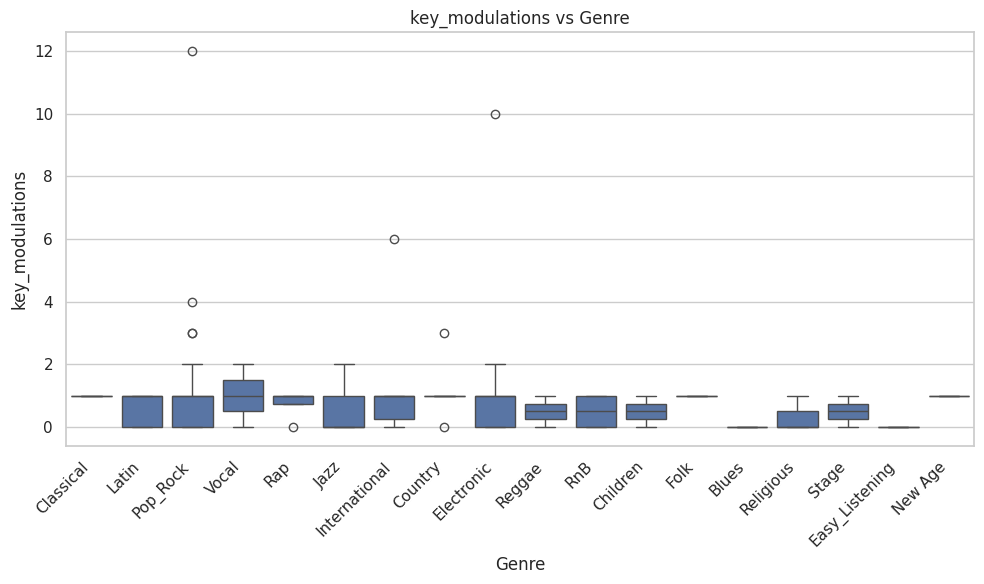

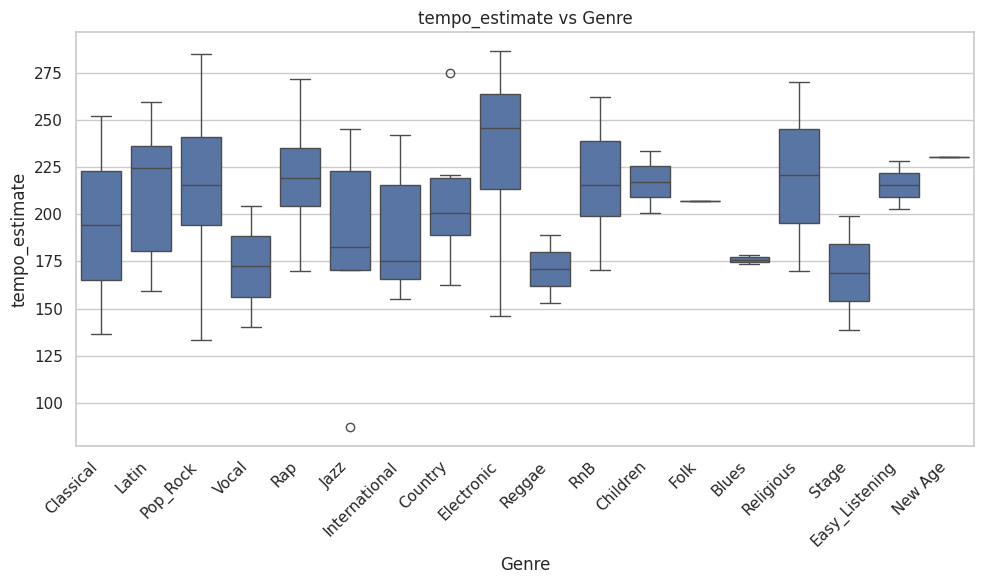

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Prepare a list of numeric features (exclude genre and non-numeric columns)
numeric_features = df_dict.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'genre_encoded']

# Create box plots for each numeric feature against genre
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='genre', y=feature, data=df_dict)
    plt.xticks(rotation=45, ha='right')  # Rotate genre labels for readability
    plt.title(f'{feature} vs Genre')
    plt.ylabel(feature)
    plt.xlabel('Genre')
    plt.tight_layout()
    plt.show()


The following box plots demonstrate each song genre vs song features represented as number of instruments, end time, average melodic interval, rhythmic variability, and key modulations. By analyzing these graphs we are able to determine the key differences of features between each genre. Understanding and pointing out the difference in features between song genres is important because this helps our model learn and understand the indications and trends associated to each genre for prediction.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


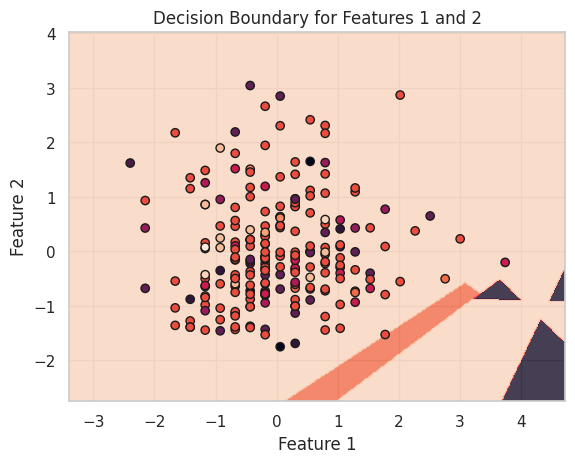

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


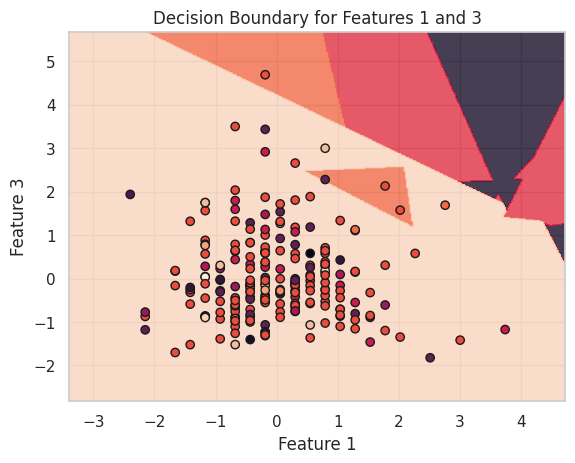

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


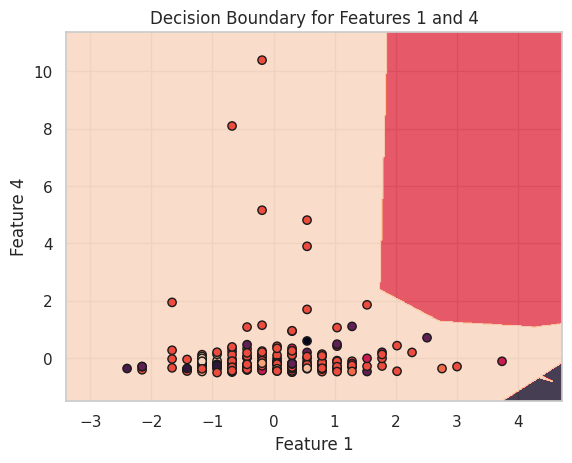

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


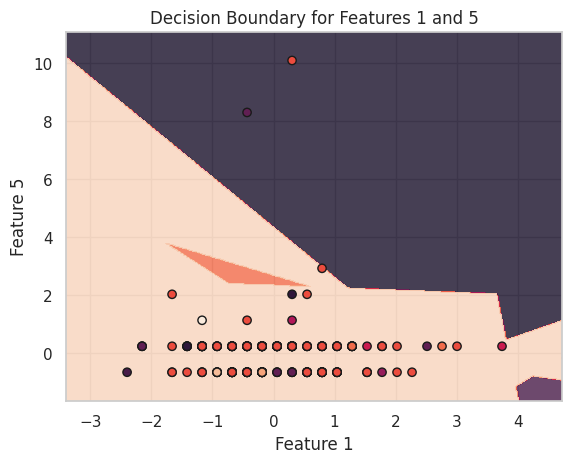

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


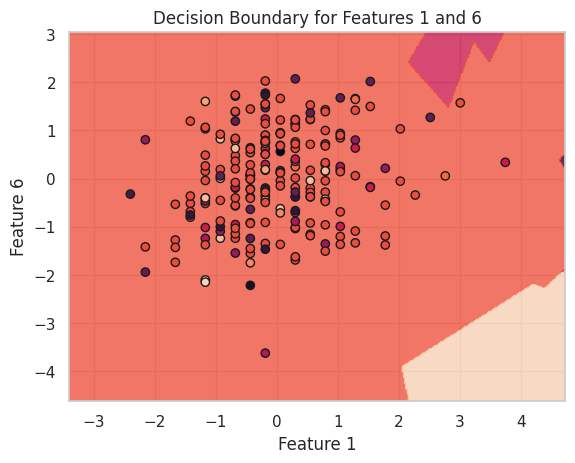

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations
from sklearn.metrics import accuracy_score

def plot_decision_boundary(X, y, model, feature_pair, title):

    h = .02  # Step size in the mesh
    f1, f2 = feature_pair  # Unpack feature indices
    X_np = X.to_numpy() # Ensure NumPy array
    X_selected = X_np[:, [f1, f2]]

    x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
    y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Ensure tuple of 2 features
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_full_features = np.zeros((grid_points.shape[0], X_np.shape[1]))
    grid_full_features[:, [f1, f2]] = grid_points

    Z = model.predict(grid_full_features)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel(f'Feature {f1 + 1}')
    plt.ylabel(f'Feature {f2 + 1}')
    plt.title(title)
    plt.show()

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Select feature pairs to visualize
feature_combinations = list(combinations(range(X_train.shape[1]), 2))
subset_combinations = feature_combinations[:5]  # Limit to first 5 pairs for visualization

# Plot decision boundaries for selected feature pairs
for feature_pair in subset_combinations:
    plot_decision_boundary(
        X_train,
        y_train,
        svm_model,
        feature_pair,
        title=f'Decision Boundary for Features {feature_pair[0] + 1} and {feature_pair[1] + 1}'
    )


# Milestone 4:

Tuning our parameters more in the preprocessing process and then training on KNN.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Load the data
df_dict = pd.read_csv('dictionary_data.csv')

# Separate numeric and non-numeric data
numeric_cols = df_dict.select_dtypes(include=np.number).columns
non_numeric_cols = df_dict.select_dtypes(exclude=np.number).columns

# Handle numeric columns
numeric_imputer = SimpleImputer(strategy='most_frequent')
df_numeric = pd.DataFrame(
    numeric_imputer.fit_transform(df_dict[numeric_cols]),
    columns=numeric_cols
)

# Handle non-numeric columns
df_non_numeric = df_dict[non_numeric_cols].copy()

note_counts = df_dict['note_counts']
note_counts = note_counts.apply(eval)
# Define a function to compute features for each list of note counts
def compute_note_count_features(x):
    if not x or len(x) == 0:  # Handle empty lists
        return pd.Series({
            'note_count_mean': np.nan,
            'note_count_std': np.nan,
            'note_count_sum': 0,
            'note_count_entropy': 0,
        })
    return pd.Series({
        'note_count_mean': np.mean(x),
        'note_count_std': np.std(x),
        'note_count_sum': np.sum(x),
        'note_count_entropy': entropy(x) if len(x) > 1 else 0
    })

avg_durations = df_dict['avg_note_durations']
avg_durations = avg_durations.apply(eval)
avg_durations_features = avg_durations.apply(
    lambda x: pd.Series({
        'duration_mean': np.mean(x) if len(x) > 0 else np.nan,
        'duration_std': np.std(x) if len(x) > 0 else np.nan
    })
)


avg_velocities = df_dict['avg_velocities']
avg_velocities = avg_velocities.apply(eval)
avg_velocities_features = avg_velocities.apply(
    lambda x: pd.Series({
        'velocity_mean': np.mean(x) if len(x) > 0 else np.nan,
        'velocity_std': np.std(x) if len(x) > 0 else np.nan
    })
)

# Apply the function to compute features
note_counts_features = note_counts.apply(compute_note_count_features)

program_numbers = df_dict['program_numbers']
drum_patterns = df_dict['drum_patterns']
program_numbers = program_numbers.apply(eval)
drum_patterns = drum_patterns.apply(eval)
all_drum_patterns = set([pattern for row in drum_patterns for pattern in row])
all_program_numbers = set([program for row in program_numbers for program in row])
def one_hot_encode(row, unique_values):
    return pd.Series({value: int(value in row) for value in unique_values})

# Apply one-hot encoding to drum_patterns
drum_patterns_encoded = drum_patterns.apply(one_hot_encode, args=(all_drum_patterns,))
drum_patterns_encoded.columns = [f"drum_pattern_{col}" for col in drum_patterns_encoded.columns]

# Apply one-hot encoding to program_numbers
program_numbers_encoded = program_numbers.apply(one_hot_encode, args=(all_program_numbers,))
program_numbers_encoded.columns = [f"program_number_{col}" for col in program_numbers_encoded.columns]

has_drums = df_dict['has_drums']
has_drums_numeric = has_drums.astype(int)
has_drums_numeric = has_drums_numeric.fillna(0)

# Combine numeric and processed non-numeric columns
df_processed = pd.concat([df_numeric, note_counts_features, avg_velocities_features, avg_durations_features], axis=1)

# Scale numeric data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_processed),
    columns=df_processed.columns
)

columns_to_expand = df_scaled.columns

poly = PolynomialFeatures(degree=2, include_bias=False)
expanded_features = poly.fit_transform(df_scaled[columns_to_expand])

expanded_columns = poly.get_feature_names_out(columns_to_expand)
df_expanded = pd.DataFrame(expanded_features, columns=expanded_columns)

# Convert back to DataFrame for expanded features
# expanded_df = pd.concat([df_expanded, drum_patterns_encoded, program_numbers_encoded, has_drums_numeric], axis=1)
expanded_df = pd.concat([df_scaled, drum_patterns_encoded, program_numbers_encoded, has_drums_numeric], axis=1)

print(f"Preprocessed and expanded features: {expanded_df.shape}")
expanded_df['genre'] = df_dict['genre']


# getting our df without the genre as that is our target
df_norm = expanded_df.drop(columns='genre')

# Encode the 'genre' column (target) using LabelEncoder
label_encoder = LabelEncoder()
expanded_df['genre_encoded'] = label_encoder.fit_transform(expanded_df['genre'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_norm, expanded_df['genre_encoded'], test_size=0.20, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# # Trying to resample the data
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler

# smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)
# random = RandomOverSampler(random_state=42)
# Xrandom, yRandom = random.fit_resample(X_train, y_train)
# X_resampled, y_resampled = smote.fit_resample(Xrandom, yRandom)

# # Plotting to make sure the features are evenly distributed
# plt.figure(figsize=(25, 15))
# plt.hist(label_encoder.inverse_transform(y_resampled),  edgecolor='black', bins = expanded_df['genre_encoded'].unique().max())
# plt.show()


Preprocessed and expanded features: (279, 210)
Training data shape: (223, 210)
Testing data shape: (56, 210)
Training labels shape: (223,)
Testing labels shape: (56,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Prepare features and target
X = df_norm
y = expanded_df['genre']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
train_accuracy_scores = []

# Initialize KNN
neighbor = KNeighborsClassifier()

for fold, (train_index, val_index) in enumerate(kf.split(X, y_encoded)):
    # Split the data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Oversample the training data
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # Train the KNN model
    neighbor.fit(X_resampled, y_resampled)

    # Validate the model
    y_val_pred = neighbor.predict(X_val)
    y_train_pred = neighbor.predict(X_train)

    # Get stats
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Add metrics to their respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    train_accuracy_scores.append(train_accuracy)

    print(f"Fold {fold + 1}/{k} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Report cross-validation metrics
print("\nCross-Validation Metrics:")
print(f"Training Accuracy: {np.mean(train_accuracy_scores):.4f}")
print(f"Validation Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-Score: {np.mean(f1_scores):.4f}")


Fold 1/5 - Accuracy: 0.2857, Precision: 0.4009, Recall: 0.2857, F1: 0.3180
Fold 2/5 - Accuracy: 0.2143, Precision: 0.4657, Recall: 0.2143, F1: 0.2652
Fold 3/5 - Accuracy: 0.3214, Precision: 0.4748, Recall: 0.3214, F1: 0.3619
Fold 4/5 - Accuracy: 0.1429, Precision: 0.4565, Recall: 0.1429, F1: 0.2052
Fold 5/5 - Accuracy: 0.2364, Precision: 0.6260, Recall: 0.2364, F1: 0.3278

Cross-Validation Metrics:
Training Accuracy: 0.6675
Validation Accuracy: 0.2401
Precision: 0.4848
Recall: 0.2401
F1-Score: 0.2956


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder

# Prepare features and target
X = df_norm
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(expanded_df['genre'])  # Encode genre as 1D array of class labels

# Initialize the classifier
clf = KNeighborsClassifier()

# Stratified k-fold cross-validation
sk_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(clf, X, y, cv=sk_folds)
cross = cross_validate(clf, X, y, cv=sk_folds, return_train_score=True)

# Print results
print("Average Test Score: ", scores.mean())
print("Average Train Score: ", cross['train_score'].mean())


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Average Test Score:  0.4875661375661375
Average Train Score:  0.6156912034402074


In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error as mse

clf.fit(X_train, y_train)


train_pred_linear = clf.predict(X_train)
test_pred_linear = clf.predict(X_test)

# Calculate metrics
train_accuracy = mse(y_train, train_pred_linear)
test_accuracy = mse(y_test, test_pred_linear)

train_accuracy_acc = accuracy_score(y_train, train_pred_linear)
test_accuracy_acc = accuracy_score(y_test, test_pred_linear)

print(train_accuracy)
print(test_accuracy)
print(train_accuracy_acc)
print(test_accuracy_acc)


12.852678571428571
17.553571428571427
0.6205357142857143
0.5892857142857143


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Prepare features and target
X = df_norm
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(expanded_df['genre'])  # Encode target labels

# Oversampler
oversampler = RandomOverSampler(random_state=42)

# Initialize KFold
k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=42)
scores = []

# Initialize Random Forest
clf = RandomForestClassifier(random_state=25, n_jobs=-1)

# Cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split the data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Oversample training data
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Train the Random Forest model
    clf.fit(X_train_resampled, y_train_resampled)

    # Validate the model
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    scores.append(accuracy)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Report cross-validation accuracy
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {np.mean(scores):.4f}")

# Train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

# Oversample training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Train final model
clf.fit(X_train_resampled, y_train_resampled)

# Test predictions
test_pred = clf.predict(X_test)

# Classification report
print("\nTest Classification Report:")
print(classification_report(y_test, test_pred, zero_division=0))

# Decode and print predictions
print("Predicted Labels:", label_encoder.inverse_transform(test_pred))
print("Actual Labels:", label_encoder.inverse_transform(y_test))




Fold 1: Accuracy = 0.4571
Fold 2: Accuracy = 0.5143
Fold 3: Accuracy = 0.5429
Fold 4: Accuracy = 0.5429
Fold 5: Accuracy = 0.6571
Fold 6: Accuracy = 0.6286


In [ ]:
mean_cv_accuracy = np.mean(scores)

# Train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

# Oversample training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Train final model
clf.fit(X_train_resampled, y_train_resampled)

# Train predictions
train_pred = clf.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, train_pred)

# Test predictions
test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)

# Classification report for test set
test_classification_report = classification_report(y_test, test_pred, zero_division=0)

print(train_accuracy)

print(test_accuracy)

print(mean_cv_accuracy)

print(test_classification_report)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_mse = mean_squared_error(y_train, clf.predict(X_train))
test_mse = mean_squared_error(y_test, clf.predict(X_test))

train_mae = mean_absolute_error(y_train, clf.predict(X_train))
test_mae = mean_absolute_error(y_test, clf.predict(X_test))

print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")